In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

import random

SEED = 31415926
random.seed(SEED)
np.random.seed(SEED)

In [2]:
DATA_PATH = "data/Copy of 2023_02_21_Copy of Single cell studies database_final.csv"
# DATA_PATH = "http://www.nxn.se/single-cell-studies/data.tsv"

In [3]:
df = pd.read_csv(DATA_PATH, index_col=0)
df

,Shorthand,DOI,Number individuals,N_individulas sentence,chatgpt_sentence,Organism,Reported cells total,Tissue,Tissue_type,tissue_accessibility,...,Developmental stage,Number of reported cell types or clusters,Cell clustering,Pseudotime,RNA Velocity,PCA,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID
0,Cauli et al PNAS,10.1073/pnas.97.11.6144,NaN,NaN,NaN,Rat,85,Brain,NaN,NaN,...,21-27 days,3.0,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN
1,Malnic et al Cell,10.1016/S0092-8674(00)80581-4,NaN,NaN,NaN,Mouse,18,Brain,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tietjen et al Neuron,10.1016/S0896-6273(03)00229-0,2.0,This prompted us to harvest OSNs and OPCs from...,There is no specific information given in the ...,"Human, Mouse",37,Brain,Brain,3.0,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,"Manual, LCM",NaN
3,Gallopin et al CCortex,10.1093/cercor/bhj081,NaN,NaN,NaN,Rat,157,Brain,NaN,NaN,...,21-27 days,4.0,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN
4,Kurimoto et al NAR,10.1093/nar/gkl050,NaN,NaN,NaN,Mouse,20,ICM,NaN,NaN,...,E3.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,O'Brien et al bioRxiv,10.1101/2022.12.20.521287,NaN,NaN,NaN,Mouse,"16,434",Stomach,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816,Knight-Schrijver et al NCR,10.1038/s44161-022-00183-w,7.0,NaN,Single-cell RNA sequencing data were analyzed ...,Human,"60,668",Heart,Cardiovascular system,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1817,Tietscher et al NCommunications,10.1038/s41467-022-35238-w,14.0,NaN,Single-cell RNA sequencing data was analyzed f...,Human,"120,000",Tumor,Tumor,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1818,de Jonghe et al bioRxiv,10.1101/2023.01.12.523500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
is_included = (df["Tissue"] != "Culture") & \
              (df["Tissue"] != "Cullture") & \
              (df["Tissue"] != "Organoid") & \
              (df["Tissue"] != "Xenograft") & \
              (df["Organism"].str.contains("Human")) & \
              (df["excluded"].isna())

print("Before exclusion:", df.shape)
df = df.loc[is_included, :]
print("After exclusion:", df.shape)

Before exclusion: (1820, 33)
After exclusion: (630, 33)


In [5]:
df["Number individuals"].notna().sum()

630

In [6]:
df["Organism"].value_counts()

Human                                                                        545
Human, Mouse                                                                  67
Mouse, Human                                                                   6
Human, Macaque                                                                 2
Human, Rhesus, Rat, Mouse, Rabbit, Pig                                         1
Human, Mouse, Pig                                                              1
Human, Frog                                                                    1
Human, Zebrafish, Chicken, Marmoset, Sheep, Hamster, Mouse, Rat, Mole rat      1
Crab-eating macaque, Human                                                     1
Mouse, Human, Dog                                                              1
Cynomolgus macaque, Human, Mouse, Pig, Rhesus macaque                          1
Bonobo, Chimpanzee, Human, Macaque                                             1
Human, Macaque, Mouse       

In [7]:
df["Tissue_type"].value_counts()

Blood                     127
Brain                      98
Several                    66
Digestive system           52
Tumor                      45
Respiratory system         37
Reproductive system        33
Bone marrow                26
Pancreas                   24
Cardiovascular system      19
Urinary system             19
Musculoskeletal system     17
Visual system              16
Skin                       15
Lymphoid system            12
Breast                      9
Embryo                      8
Adipose                     3
Cerebrospinal fluid         2
Xenodraft                   1
Endocrine system            1
Name: Tissue_type, dtype: int64

In [8]:
df["tissue_accessibility"].value_counts()

3.0    458
1.0    129
2.0     43
Name: tissue_accessibility, dtype: int64

In [9]:
def get_date(number):
    """Extract year, month and day from the date in form of integer number
    
    Examples
    --------
    >>> get_date(20020726)
    (2020, 26, 07)
    """

    if "/" in number:
        day, month, year = number.split("/")

    else:
        if len(str(number)) != 8:
            raise ValueError(f"{number} has incorrect format")

        number = str(number)
        year = number[:4]
        month = number[4:6]
        day = number[6:]

    return year, month, day


def remove_comma_from_number(s):
    if isinstance(s, str):
        return s.replace(",", "")
    
    return s

In [10]:
dates = df["Publication date"].apply(get_date).values
df["date"] = [f"{year}-{month}-{day}" for year, month, day in dates]

df["year"] = [date[0] for date in dates]
df["month"] = [date[1] for date in dates]
df["day"] = [date[2] for date in dates]

df["date"] = pd.to_datetime(df["date"])

df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["day"] = df["day"].astype(int)

df["Reported cells total"] = df["Reported cells total"].apply(remove_comma_from_number)
df["Reported cells total"] = df["Reported cells total"].astype(float)
df["cells_per_donor"] = df["Reported cells total"] / df["Number individuals"]

df = df.loc[df["year"] < 2023]  # The data for 2023 is not complete yet

/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_1767/3918915927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = [f"{year}-{month}-{day}" for year, month, day in dates]
/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_1767/3918915927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = [date[0] for date in dates]
/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_1767/3918915927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

<Axes: xlabel='date', ylabel='Number individuals'>

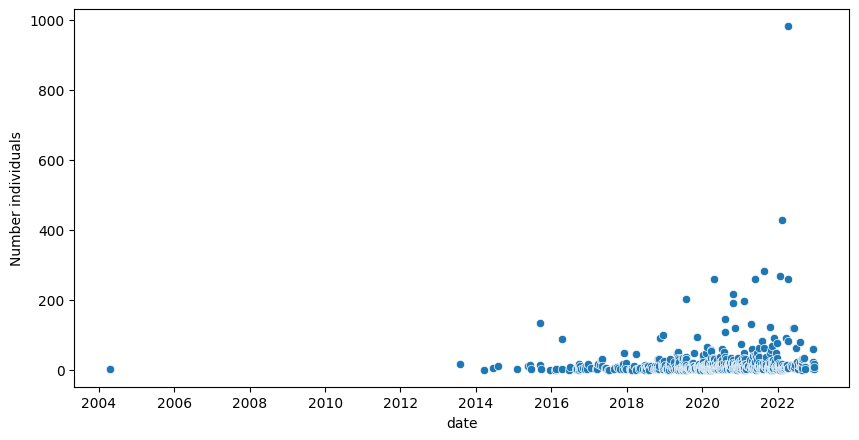

In [11]:
plt.figure(figsize=(10, 5), dpi=100)

sns.scatterplot(data=df, x="date", y="Number individuals")

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

<Axes: xlabel='Number individuals', ylabel='Count'>

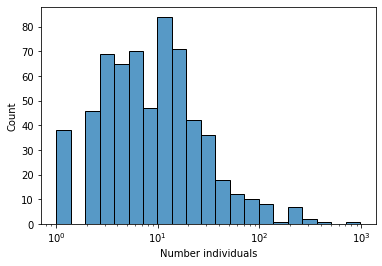

In [12]:
sns.histplot(df["Number individuals"], log_scale=True)
# plt.yscale("log")

In [13]:
df[["Number individuals"]].describe()

,Number individuals
count,628.000000
mean,20.085987
std,53.505285
min,1.000000
25%,4.000000
50%,8.000000
75%,17.000000
max,982.000000


<Axes: xlabel='date', ylabel='Number individuals'>

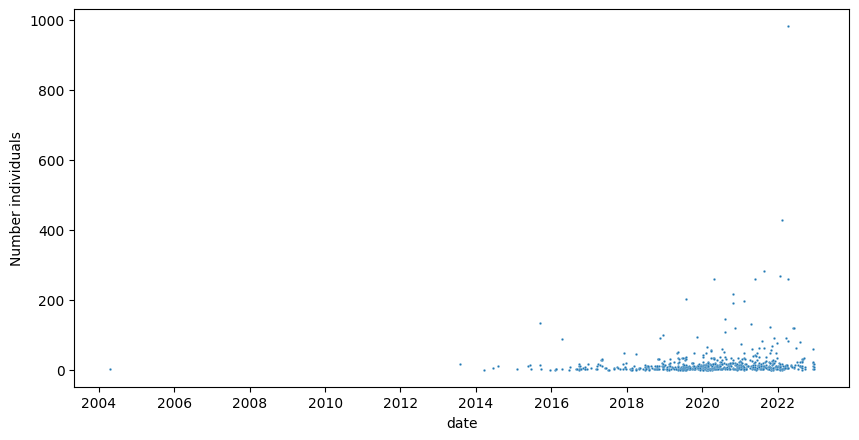

In [14]:
plt.figure(figsize=(10, 5), dpi=100)

sns.scatterplot(data=df, x="date", y="Number individuals", s=3)

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))

In [15]:
df["paper"] = 1  # It will help to calculate number of papers

(2013.0, 2024.0, 0.0, 420.0)

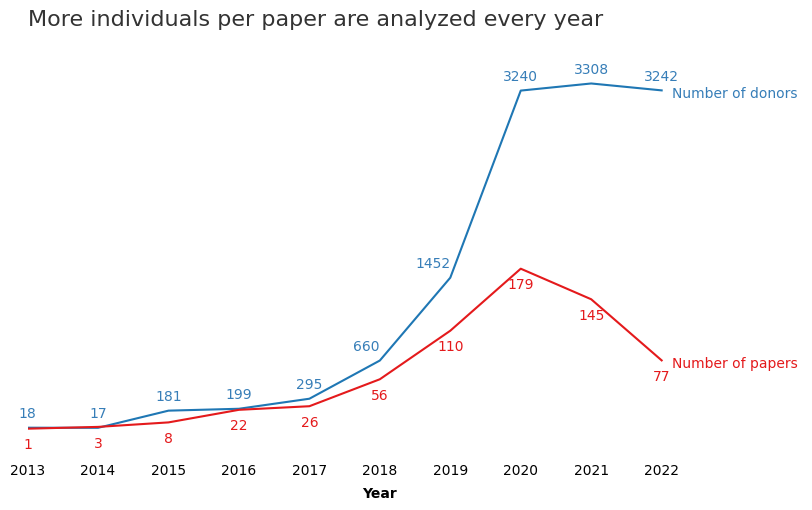

In [16]:
df_by_year = df.groupby("year").sum().reset_index()
df_by_year = df_by_year.loc[df_by_year["year"] > 2004]

plt.figure(figsize=(10, 5), dpi=100)
g = sns.lineplot(data=df_by_year, x="year", y="Number individuals")
# g = sns.scatterplot(data=df_by_year, x="year", y="Number individuals")
g.set(xticks=df_by_year["year"])

ax1 = plt.gca()
ax1.set_ylim(0, df_by_year["Number individuals"].max() + 300)
ax1.set_ylabel("")
ax1.tick_params(axis="y", colors="lightblue", which="both")
ax1.set_xlabel("Year")

ax1.set_xlim(2013, 2024)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
sns.lineplot(data=df_by_year, x="year", y="paper", ax=ax2, color="#e41a1c")
ax2.set_ylim(0, 420)
ax2.set_ylabel("")
# ax2.set_yticks(ax2.get_yticks(), color="lightred")
ax2.tick_params(colors="pink", which="both")

for _, row in df_by_year.iterrows():
    alignment = "right" if row["year"] in (2018, 2019) else "center"
    
    ax1.text(x=row["year"], y=row["Number individuals"] + 100,
             s=int(row["Number individuals"]), ha=alignment, color="#377eb8")
    
    ax2.text(x=row["year"], y=row["paper"] - 22, s=int(row["paper"]), ha="center", color="#e41a1c")
    
    ax2.text(x=row["year"], y=-50, s=int(row["year"]), ha="center")

ax1.text(x=2022.15, y=3180, s="Number of donors", color="#377eb8")
ax2.text(x=2022.15, y=70, s="Number of papers", color="#e41a1c")
ax2.text(x=2018, y=-75, s="Year", ha="center", fontweight="bold")
ax2.text(x=2013, y=450, s="More individuals per paper are analyzed every year",
         ha="left", color="#333333", fontsize=16)

ax1.set_yticks([])
ax2.set_yticks([])

ax1.axis("off")
ax2.axis("off")


In [17]:
df_by_year

,year,Number individuals,Reported cells total,tissue_accessibility,Number of reported cell types or clusters,month,day,cells_per_donor,paper
1,2013,18.0,33.0,3.0,14.0,7,26,1.833333e+00,1
2,2014,17.0,1243.0,9.0,10.0,17,39,4.317636e+02,3
3,2015,181.0,16875.0,22.0,19.0,58,121,7.817293e+03,8
4,2016,199.0,45855.0,54.0,106.0,178,332,1.324278e+04,22
5,2017,295.0,464774.0,66.0,204.0,188,458,8.935226e+04,26
6,2018,660.0,2087541.0,137.0,614.0,453,939,1.855406e+05,56
7,2019,1452.0,3528765.0,295.0,696.0,780,1734,4.531957e+05,110
8,2020,3240.0,17289246.0,450.0,1999.0,981,3061,1.256448e+06,179
9,2021,3308.0,19078146.0,366.0,1456.0,980,2117,1.225431e+06,145
10,2022,3242.0,11604307.0,178.0,593.0,391,1204,4.847908e+05,77


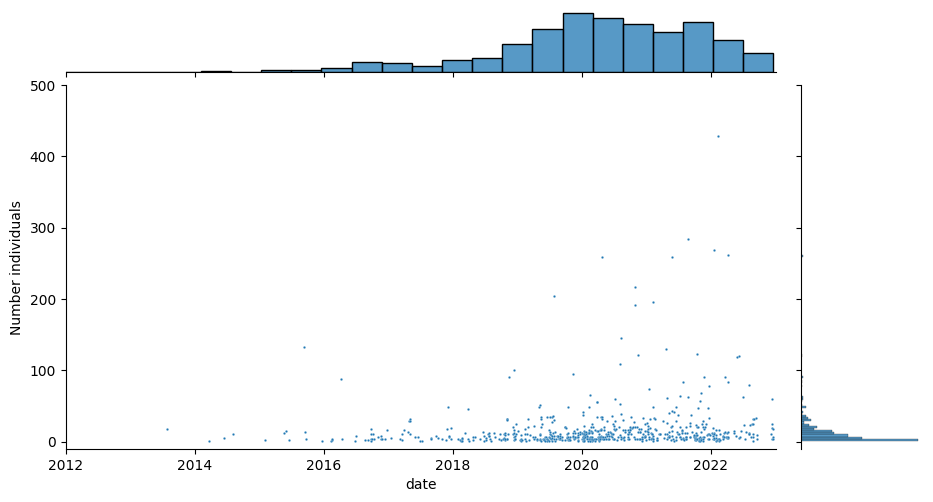

In [18]:
# plt.figure(figsize=(10, 5), dpi=100)
x_start = pd.to_datetime("01-01-2012")
x_end = pd.to_datetime("01-06-2023")

g = sns.jointplot(data=df, x="date", y="Number individuals", s=3, xlim=(x_start, x_end), ylim=(-10, 500))
g.fig.set_size_inches((10, 5))
g.fig.set_dpi(100)
# g.ax_joint.set_yscale("log")

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
# plt.ylim(0, 500);

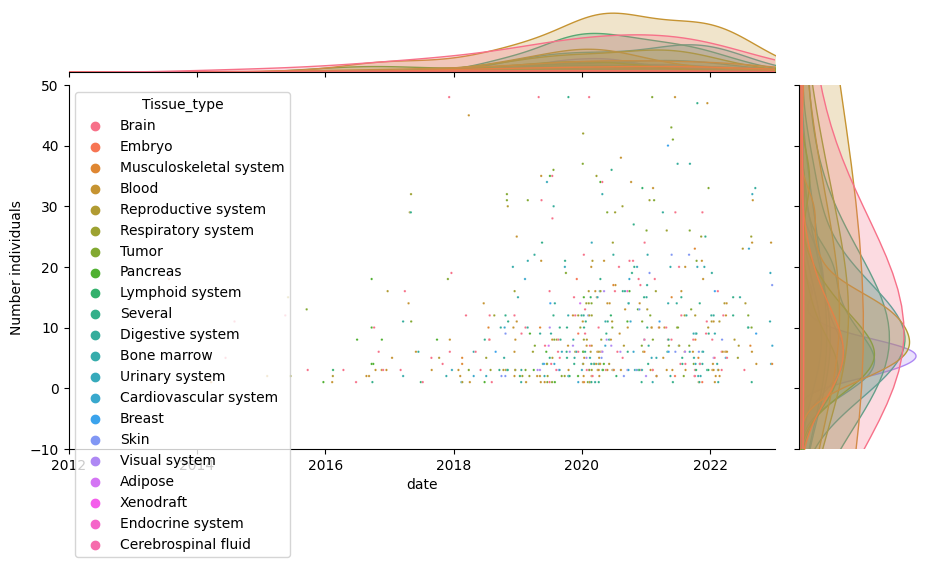

In [19]:
# plt.figure(figsize=(10, 5), dpi=100)
x_start = pd.to_datetime("01-01-2012")
x_end = pd.to_datetime("01-06-2023")

g = sns.jointplot(data=df, x="date", y="Number individuals", s=3, xlim=(x_start, x_end), ylim=(-10, 50),
                 hue="Tissue_type")
g.fig.set_size_inches((10, 5))
g.fig.set_dpi(100)

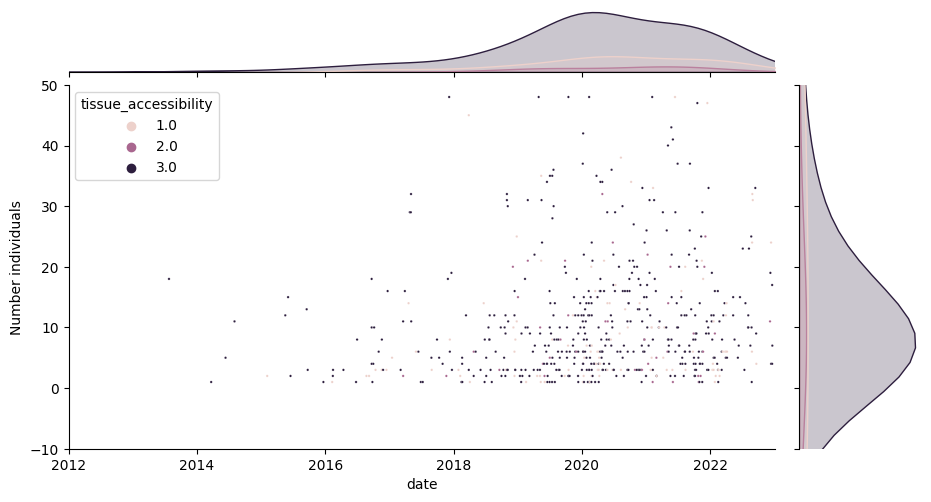

In [20]:
# plt.figure(figsize=(10, 5), dpi=100)
x_start = pd.to_datetime("01-01-2012")
x_end = pd.to_datetime("01-06-2023")

g = sns.jointplot(data=df, x="date", y="Number individuals", s=3, xlim=(x_start, x_end), ylim=(-10, 50),
                 hue="tissue_accessibility")
g.fig.set_size_inches((10, 5))
g.fig.set_dpi(100)

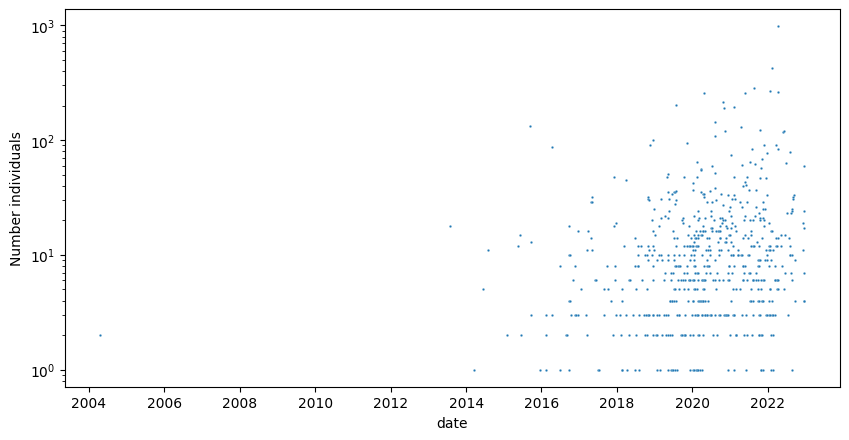

In [21]:
plt.figure(figsize=(10, 5), dpi=100)

sns.scatterplot(data=df, x="date", y="Number individuals", s=3)

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.yscale("log")

<Axes: xlabel='date', ylabel='cells_per_donor'>

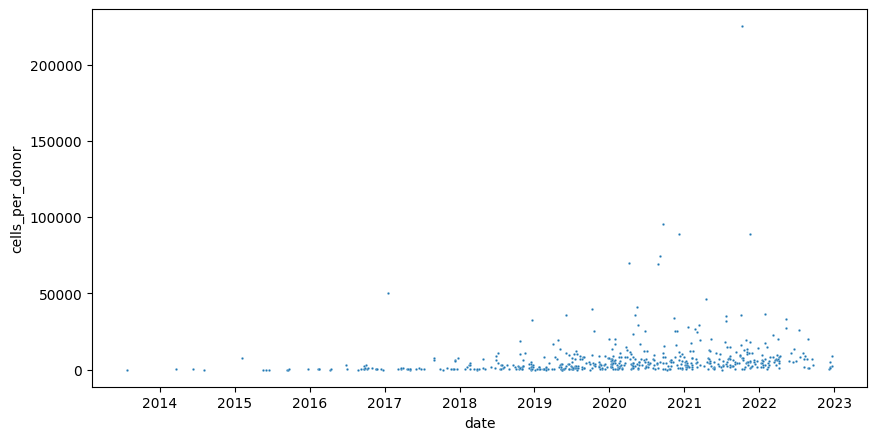

In [22]:
plt.figure(figsize=(10, 5), dpi=100)

sns.scatterplot(data=df.loc[df["year"] > 2005], x="date", y="cells_per_donor", s=3)

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
# plt.yscale("log")

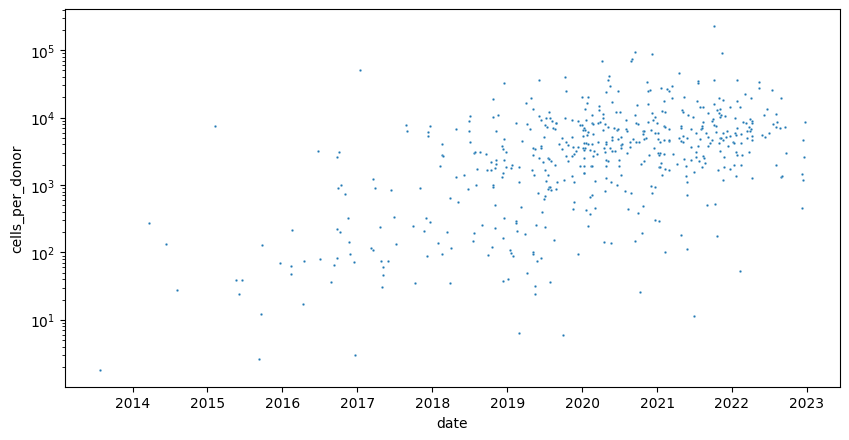

In [23]:
plt.figure(figsize=(10, 5), dpi=100)

sns.scatterplot(data=df.loc[df["year"] > 2005], x="date", y="cells_per_donor", s=3)

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.yscale("log")

In [24]:
from matplotlib import pyplot, dates
from matplotlib.ticker import FuncFormatter

df["date_number"] = dates.datestr2num(df["date"].astype(str))

In [25]:
def remove_borders(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax

Text(0, 0.5, 'Number of donors')

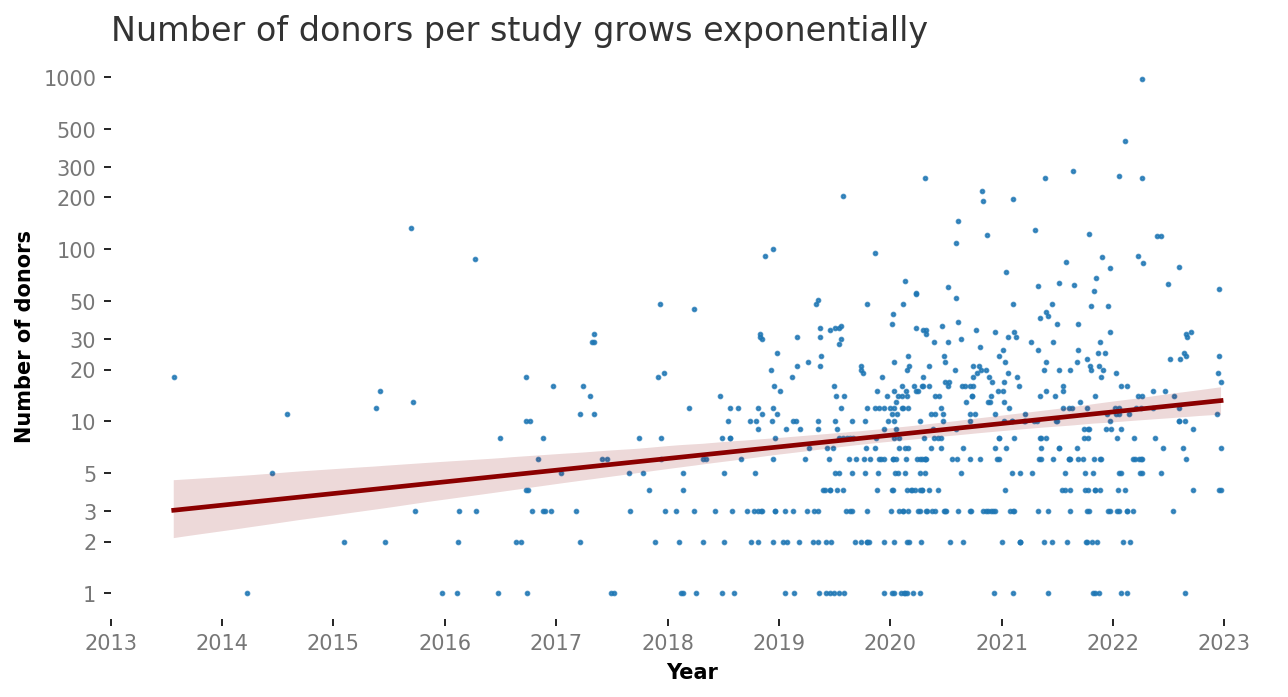

In [26]:
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return dates.num2date(x).strftime("%Y-%m-%d")

plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()

df["log_n_donors"] = np.log2(df["Number individuals"])

sns.regplot(data=df.loc[df["year"] > 2004], x="date_number", y="log_n_donors", ax=ax,
           line_kws={"color": "darkred"}, scatter_kws={"s": 3})


years = np.arange(2013, 2024)
xticks = [f"{year}-01-01" for year in years]
ax.set_xticks(dates.datestr2num(xticks), labels=years, color="#777777")
# ax.xaxis.set_major_formatter(FuncFormatter(fake_dates))

# yticks = np.power(2, np.arange(11))
yticks = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300, 500, 1000])
ax.set_yticks(ticks=np.log2(yticks), labels=yticks, color="#777777")
plt.title("Number of donors per study grows exponentially",
          color="#333333", fontsize=16, loc="left")

ax = remove_borders(ax)

plt.xlabel("Year", fontweight="bold")
plt.ylabel("Number of donors", fontweight="bold")

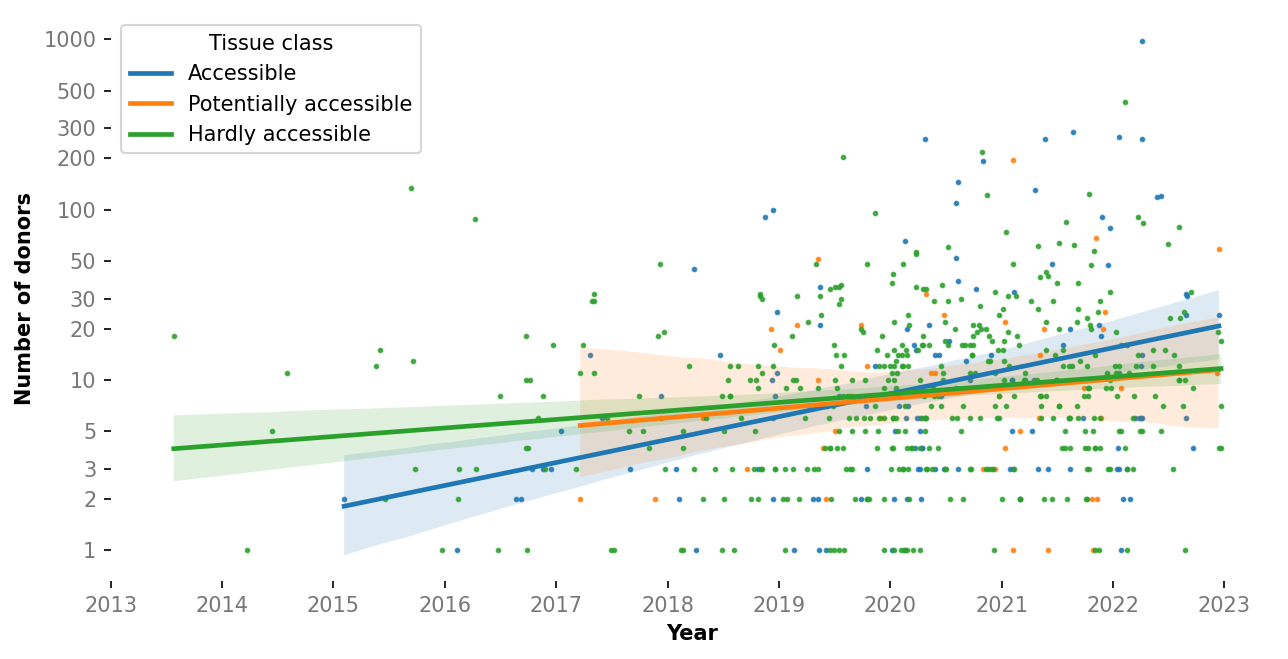

In [29]:
plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()

accessibility_types = {
    1.: "Accessible",
    2.: "Potentially accessible",
    3.: "Hardly accessible"
}

for tissue_type in sorted(df["tissue_accessibility"].unique()):
    data = df.loc[(df["year"] > 2004) & (df["tissue_accessibility"] == tissue_type)]
    sns.regplot(data=data, x="date_number", y="log_n_donors", ax=ax,
                scatter_kws={"s": 3}, line_kws={"label": accessibility_types[tissue_type]})


years = np.arange(2013, 2024)
xticks = [f"{year}-01-01" for year in years]
ax.set_xticks(dates.datestr2num(xticks), labels=years, color="#777777")
# ax.xaxis.set_major_formatter(FuncFormatter(fake_dates))

# yticks = np.power(2, np.arange(11))
yticks = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300, 500, 1000])
ax.set_yticks(ticks=np.log2(yticks), labels=yticks, color="#777777")
# plt.title("Number of donors per study grows exponentially", color="#333333", fontsize=16, loc="left")

ax = remove_borders(ax)

plt.xlabel("Year", fontweight="bold")
plt.ylabel("Number of donors", fontweight="bold")
plt.legend(title="Tissue class", )

In [30]:
def exponential_curve(x, a, b, c):
    return a * np.exp(b * x) + c

<Axes: xlabel='date_number', ylabel='Number individuals'>

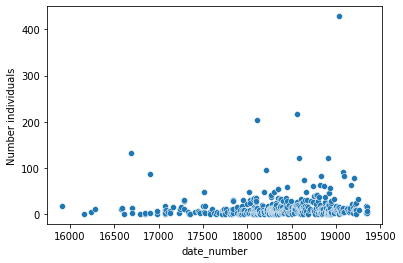

In [31]:
sns.scatterplot(data=data, x="date_number", y="Number individuals")

2 points not shown


Text(0.0, 1.0, 'Number of donors grows exponentially for easily accessible tissues')

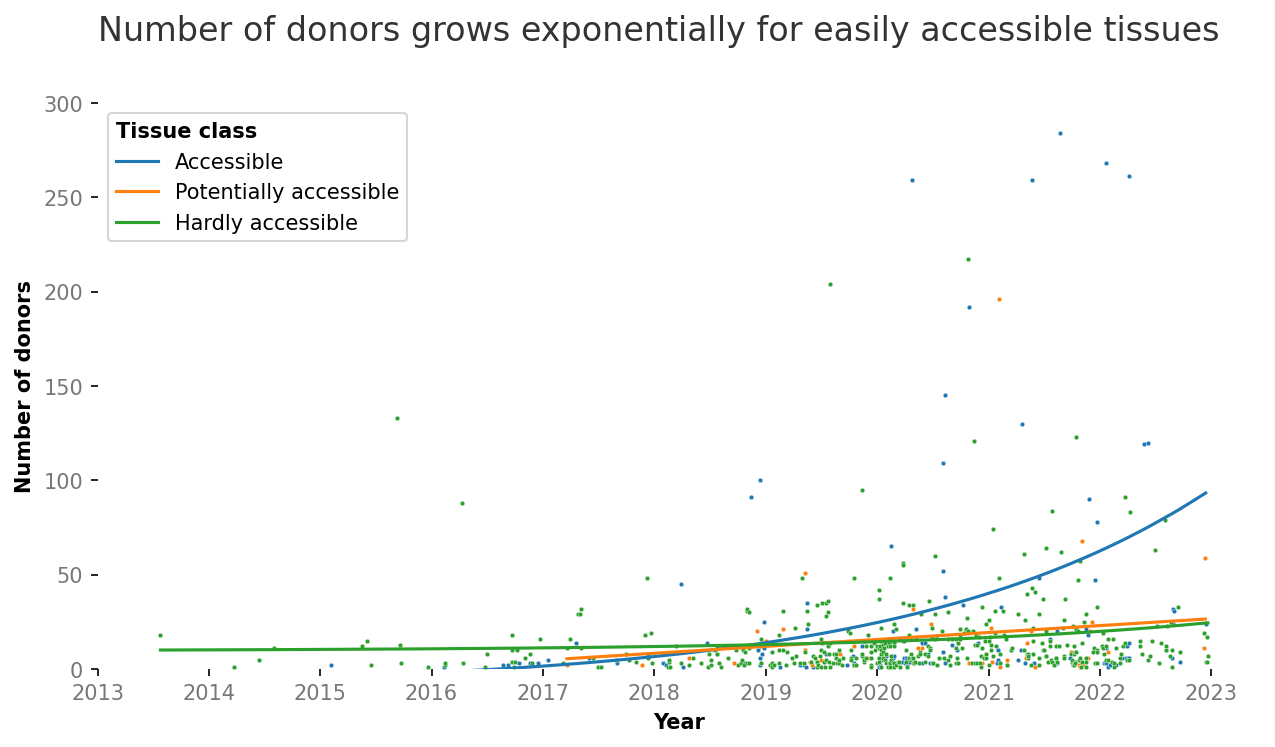

In [66]:
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()

for tissue_type in sorted(df["tissue_accessibility"].unique()):
    data = df.loc[(df["year"] > 2004) & (df["tissue_accessibility"] == tissue_type)]
    
    scaler = MinMaxScaler()
    rescaled_dates = scaler.fit_transform(data[["date_number"]]).flatten()

    coefs, covars = curve_fit(exponential_curve, rescaled_dates, data["Number individuals"],
                              method="trf", max_nfev=10000)
    predicted = exponential_curve(rescaled_dates, *coefs)

    sns.scatterplot(data=data, x="date_number", y="Number individuals", ax=ax, s=5)
    sns.lineplot(x=data["date_number"], y=predicted, ax=ax, label=accessibility_types[tissue_type])

years = np.arange(2013, 2024)
xticks = [f"{year}-01-01" for year in years]
plt.xticks(dates.datestr2num(xticks), labels=years, color="#777777")
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Number of donors", fontweight="bold")


y_max = 300
print((df["Number individuals"] > y_max).sum(), "points not shown");
plt.ylim(0, y_max)
plt.legend(title="Tissue class", alignment="left", title_fontproperties={"weight": "bold"})

yticks, _ = plt.yticks()
plt.yticks(ticks=yticks.astype(int), labels=yticks.astype(int), color="#777777")
# plt.title("Number of donors per study grows exponentially", color="#333333", fontsize=16, loc="left")

ax = remove_borders(ax)

plt.title("Number of donors grows exponentially for easily accessible tissues", pad=30,
          color="#333333", fontsize=16, loc="left")

# for label in legend.get_texts():
#     label.set_ha("left")

(0.0, 300.0)

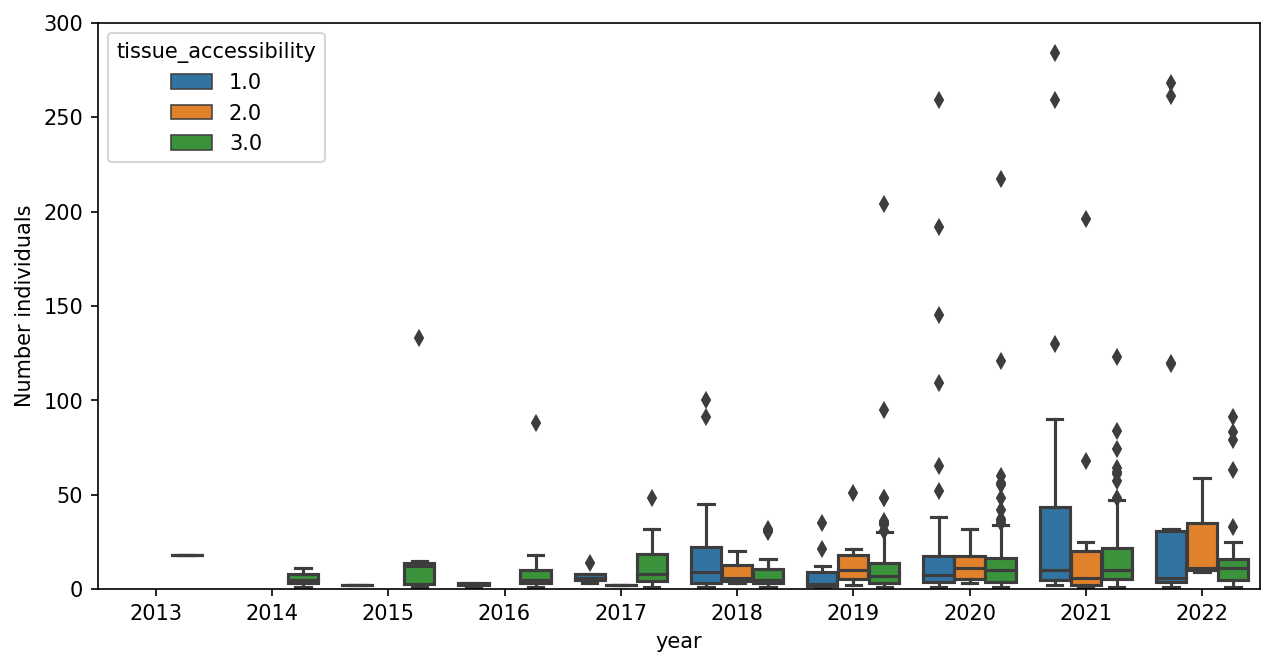

In [53]:
plt.figure(figsize=(10, 5), dpi=150)
sns.boxplot(data=df.loc[df["year"] > 2004], x="year", y="Number individuals", hue="tissue_accessibility")
plt.ylim(0, 300)

In [54]:
df_by_year_and_tissue = df.groupby(["year", "Tissue_type"]).aggregate(sum).reset_index()

In [55]:
palette = [
    (31, 119, 180),  # blue
    (255, 127, 14),  # orange
    (44, 160, 44),   # green
    (214, 39, 40),   # red
    (148, 103, 189), # purple
    (140, 86, 75),   # brown
    (227, 119, 194), # pink
    (127, 127, 127), # gray
    (188, 189, 34),  # yellow-green
    (23, 190, 207),  # turquoise
    (174, 199, 232), # light blue
    (255, 187, 120), # light orange
    (152, 223, 138), # light green
    (255, 152, 150), # light red
    (197, 176, 213), # light purple
    (196, 156, 148), # light brown
    (247, 182, 210), # light pink
    (199, 199, 199), # light gray
    (219, 219, 141), # light yellow-green
    (158, 218, 229), # light turquoise
    (203, 213, 232), # very light blue
]
palette = [(r/255, g/255, b/255) for (r, g, b) in palette]

(2013.0, 2023.0)

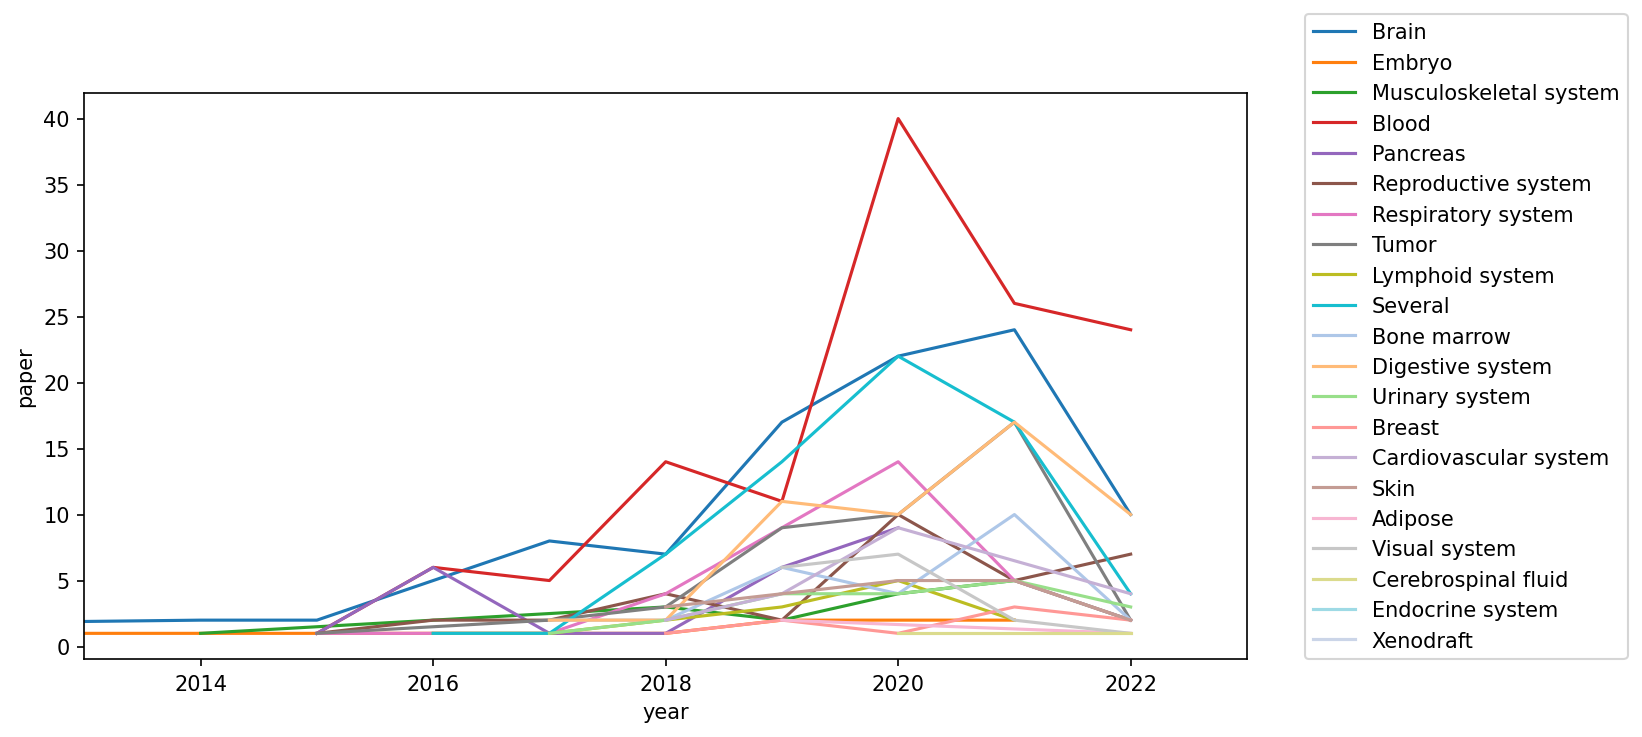

In [56]:
plt.figure(figsize=(10, 5), dpi=150)
sns.lineplot(data=df_by_year_and_tissue, x="year", y="paper", hue="Tissue_type", palette=palette)
plt.legend(loc=(1.05, 0))
plt.xlim(2013, 2023)

(2013.0, 2023.0)

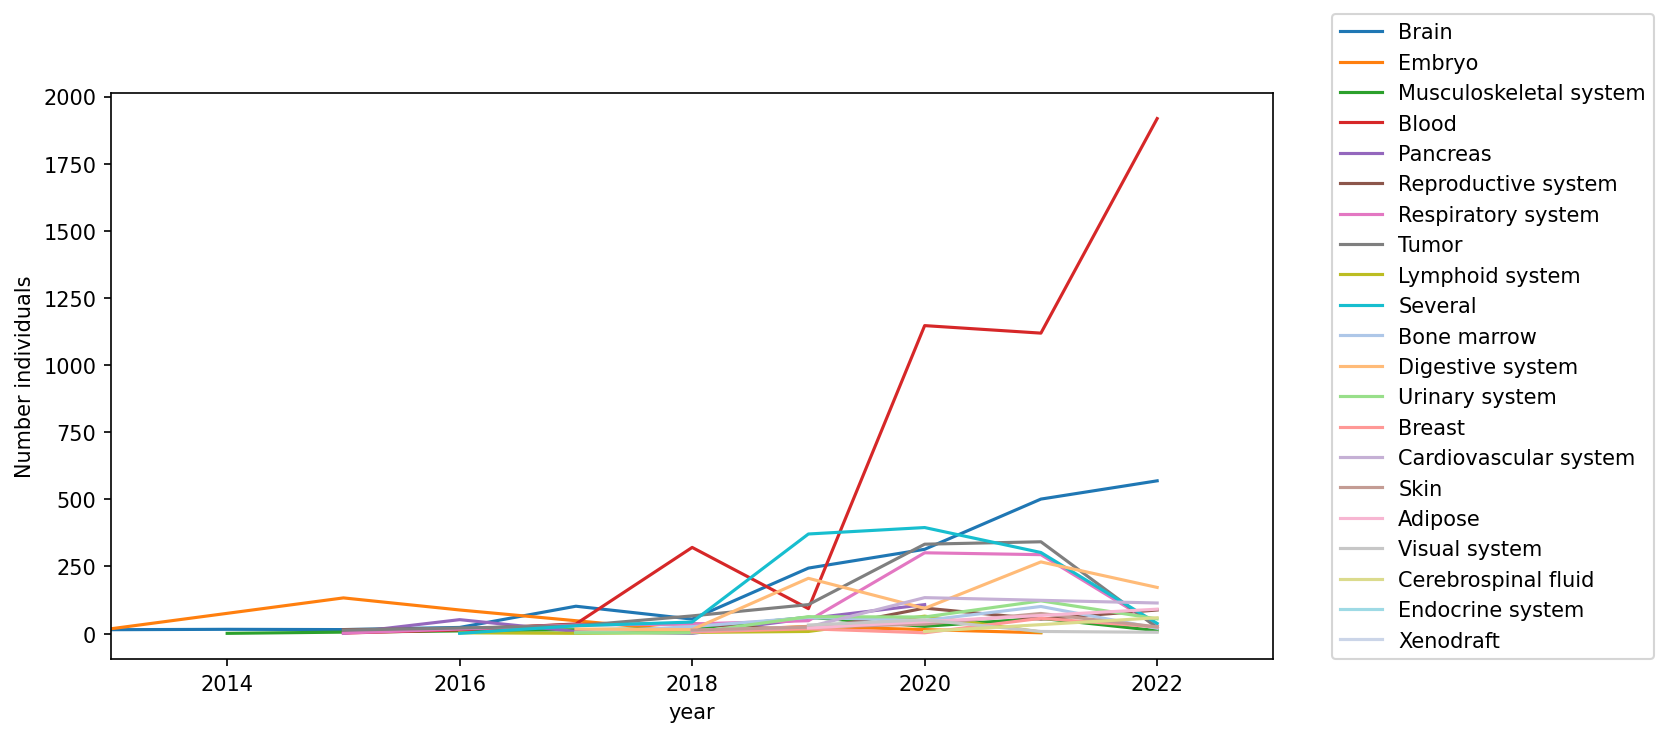

In [57]:
plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()
sns.lineplot(data=df_by_year_and_tissue, x="year", y="Number individuals", hue="Tissue_type", palette=palette)


plt.legend(loc=(1.05, 0))

plt.xlim(2013, 2023)

Text(0.0, 1.0, 'Numbers of blood and brain datasets are increasing')

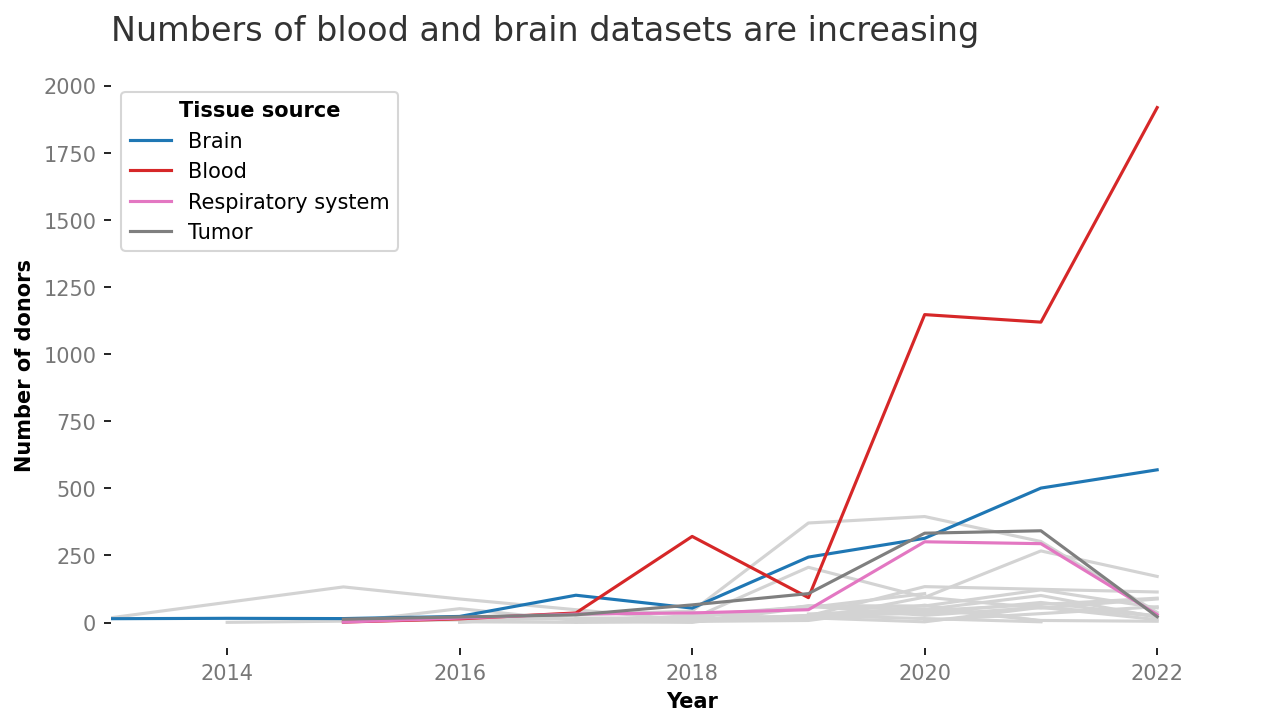

In [63]:
interesting_tissues = ("Brain", "Blood", "Respiratory system", "Tumor")
palette = [
    (31, 119, 180),  # blue
    (214, 39, 40),   # red
    (227, 119, 194), # pink
    (127, 127, 127), # gray
]
palette = [(r/255, g/255, b/255) for (r, g, b) in palette]


plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()

for tissue in df_by_year_and_tissue["Tissue_type"].unique():
    if tissue in interesting_tissues:
        continue
    
    sns.lineplot(data=df_by_year_and_tissue.loc[df_by_year_and_tissue["Tissue_type"] == tissue],
                 x="year", y="Number individuals", color="lightgray", ax=ax)

for color, tissue in zip(palette, interesting_tissues):
    sns.lineplot(data=df_by_year_and_tissue.loc[df_by_year_and_tissue["Tissue_type"] == tissue],
                 x="year", y="Number individuals", color=color, ax=ax, label=tissue)


plt.legend(title="Tissue source", title_fontproperties={"weight": "bold"})
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Number of donors", fontweight="bold")

ax = remove_borders(ax)
plt.xticks(color="#777777")
plt.yticks(color="#777777")

plt.xlim(2013, 2023)
plt.title("Numbers of blood and brain datasets are increasing", pad=20,
          color="#333333", fontsize=16, loc="left")

In [113]:
coefs

array([0.69076159, 3.9728686 , 6.03052996])

In [114]:
np.exp(coefs)

array([  1.99523451,  53.13674041, 415.93540003])

(-10.0, 50.0)

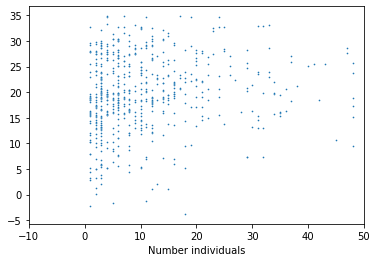

In [109]:
sns.scatterplot(x=data["Number individuals"], y=predicted, s=3)
plt.xlim(-10, 50)

Text(0, 0.5, 'Cells per donor')

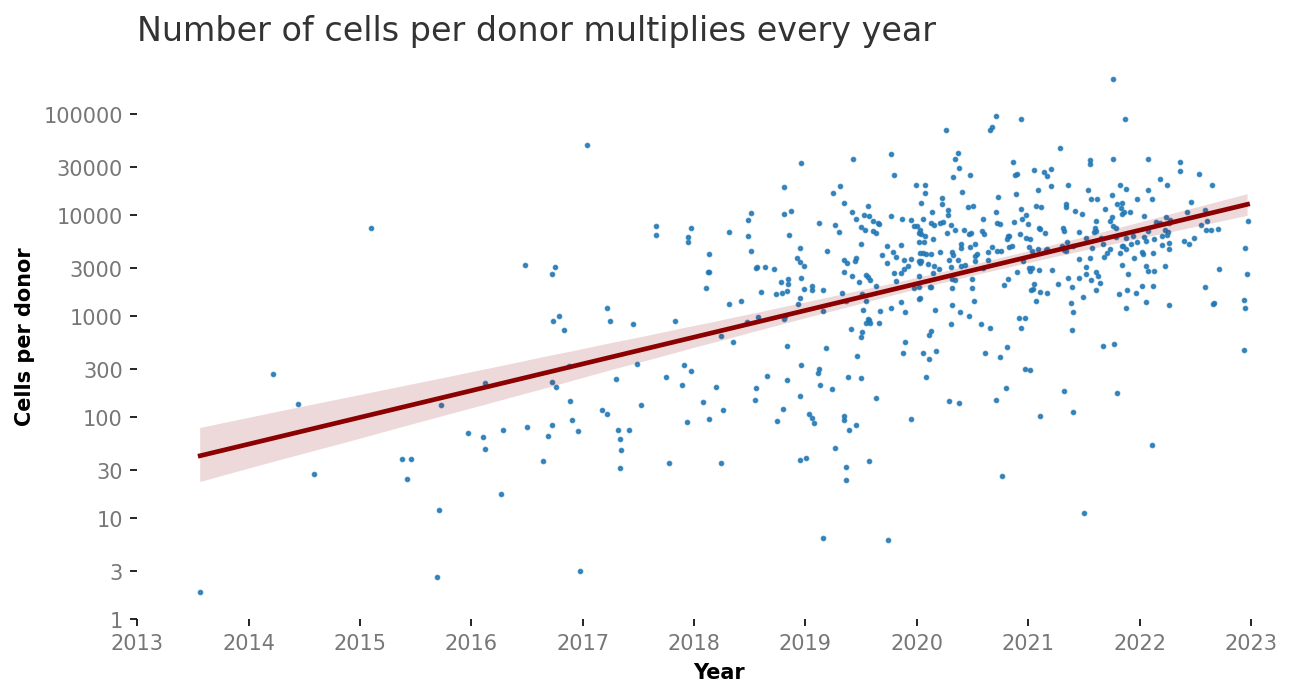

In [51]:
plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()

df["log_cells_per_donor"] = np.log2(df["cells_per_donor"])

sns.regplot(data=df.loc[df["year"] > 2004], x="date_number", y="log_cells_per_donor", ax=ax, 
           line_kws={"color": "darkred"}, scatter_kws={"s": 3})


years = np.arange(2013, 2024)
xticks = [f"{year}-01-01" for year in years]
ax.set_xticks(dates.datestr2num(xticks), labels=years, color="#777777")
# ax.xaxis.set_major_formatter(FuncFormatter(fake_dates))

# yticks = np.power(2, np.arange(11))
yticks = np.array([1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000])
ax.set_yticks(ticks=np.log2(yticks), labels=yticks, color="#777777")
plt.title("Number of cells per donor multiplies every year", color="#333333", fontsize=16, loc="left")

ax = remove_borders(ax)

plt.xlabel("Year", fontweight="bold")
plt.ylabel("Cells per donor", fontweight="bold")

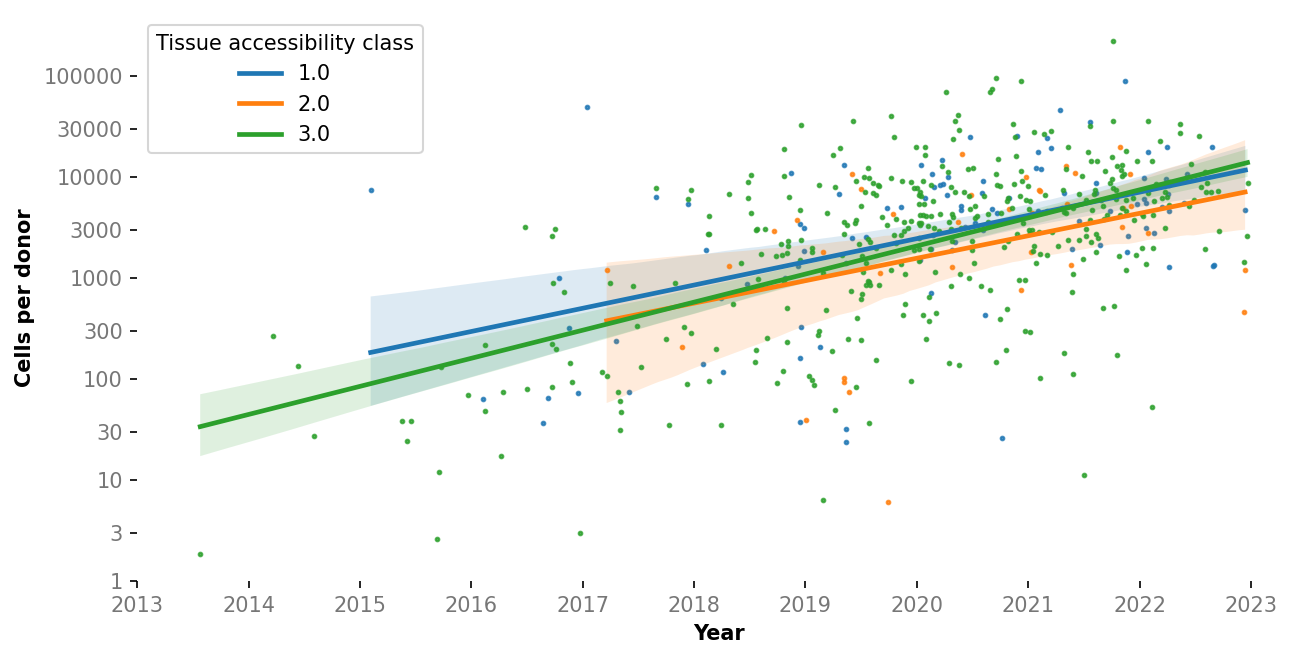

In [58]:
plt.figure(figsize=(10, 5), dpi=150)
ax = plt.gca()

for tissue_type in sorted(df["tissue_accessibility"].unique()):
    data = df.loc[(df["year"] > 2004) & (df["tissue_accessibility"] == tissue_type)]
    sns.regplot(data=data, x="date_number", y="log_cells_per_donor", ax=ax,
                scatter_kws={"s": 3}, line_kws={"label": tissue_type})


years = np.arange(2013, 2024)
xticks = [f"{year}-01-01" for year in years]
ax.set_xticks(dates.datestr2num(xticks), labels=years, color="#777777")
# ax.xaxis.set_major_formatter(FuncFormatter(fake_dates))

# yticks = np.power(2, np.arange(11))
yticks = np.array([1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000])
ax.set_yticks(ticks=np.log2(yticks), labels=yticks, color="#777777")

ax = remove_borders(ax)

plt.xlabel("Year", fontweight="bold")
plt.ylabel("Cells per donor", fontweight="bold")
plt.legend(title="Tissue accessibility class", )

Text(0.5, 0, 'Tissue accessibility class')

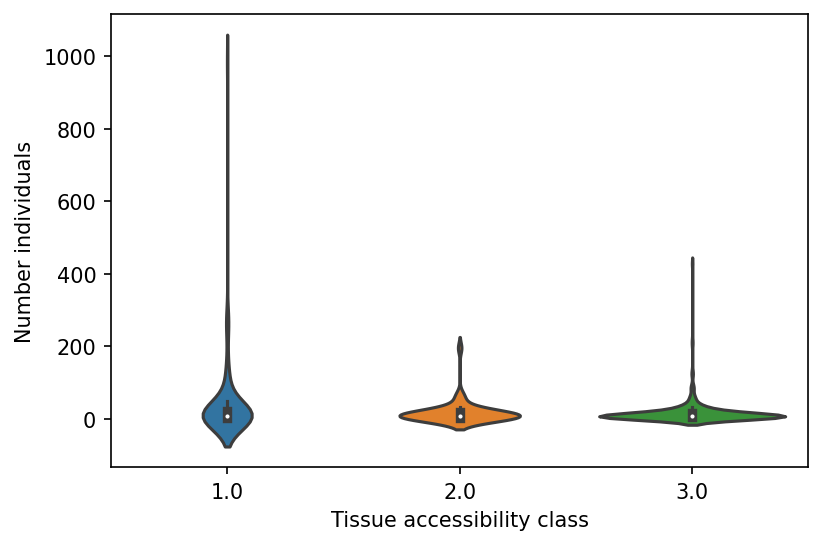

In [56]:
plt.figure(dpi=150)

sns.violinplot(data=df, x="tissue_accessibility", y="Number individuals")
plt.xlabel("Tissue accessibility class")

In [274]:
df.columns

Index(['Shorthand', 'DOI', 'Number individuals', 'N_individulas sentence',
       'chatgpt_sentence', 'Organism', 'Reported cells total', 'Tissue',
       'Contrasts', 'excluded', 'Authors', 'Journal', 'Title',
       'Publication date', 'bioRxiv DOI', 'Technique', 'Data location',
       'Panel size', 'Measurement', 'Cell source', 'Disease',
       'Developmental stage', 'Number of reported cell types or clusters',
       'Cell clustering', 'Pseudotime', 'RNA Velocity', 'PCA', 'tSNE',
       'H5AD location', 'Isolation', 'BC --> Cell ID _OR_ BC --> Cluster ID',
       'date', 'year', 'month', 'day', 'cells_per_donor', 'paper',
       'date_number', 'log_n_donors', 'log_cells_per_donor'],
      dtype='object')

In [285]:
df["log_n_cells"] = np.log2(df["Reported cells total"])

Text(0, 0.5, 'Number of cells in a study')

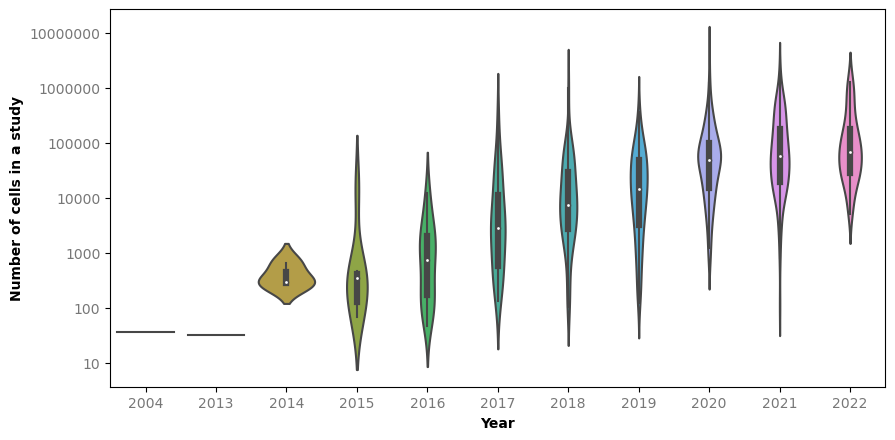

In [305]:
plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(data=df, x="year", y="log_n_cells")
yticks = np.array([10, 100, 1000, 10000, 100000, 1000000, 10000000])
plt.yticks(ticks=np.log2(yticks), labels=yticks, color="#777777")

plt.xticks(color="#777777")
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Number of cells in a study", fontweight="bold")


In [238]:
np.exp(yticks)

array([1.35335283e-01, 1.00000000e+00, 7.38905610e+00, 5.45981500e+01,
       4.03428793e+02, 2.98095799e+03, 2.20264658e+04, 1.62754791e+05])

<AxesSubplot:xlabel='cells_per_donor', ylabel='Count'>

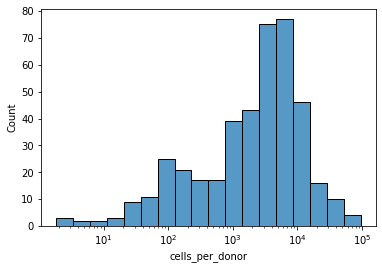

In [92]:
sns.histplot(df["cells_per_donor"], log_scale=True)

Text(0, 0.5, 'Median number of individuals')

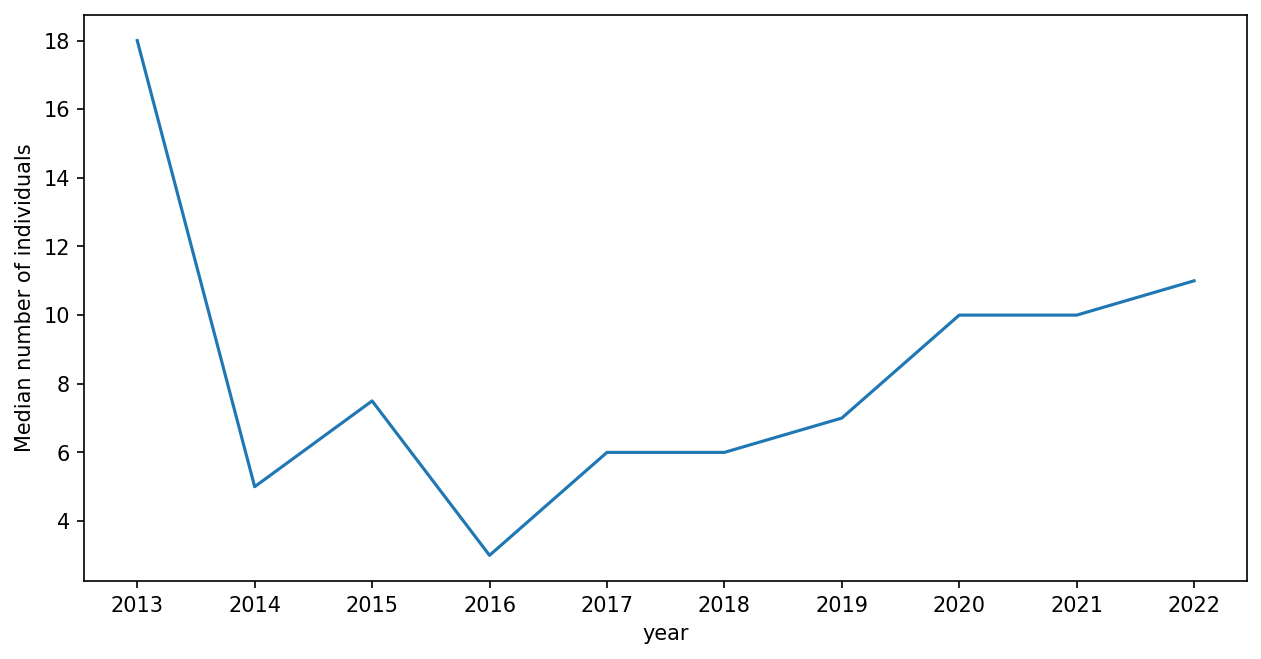

In [326]:
medians_by_year = df.groupby("year").agg(np.median).reset_index()
medians_by_year = medians_by_year.loc[medians_by_year["year"] > 2005]

plt.figure(figsize=(10, 5), dpi=150)
sns.lineplot(data=medians_by_year, x="year", y="Number individuals")
plt.xticks(medians_by_year["year"])

plt.ylabel("Median number of individuals")

In [322]:
medians_by_year

,year,Number individuals,Reported cells total,Number of reported cell types or clusters,month,day,cells_per_donor,paper,date_number,log_n_donors,log_cells_per_donor,log_n_cells
0,2004,2.0,37.0,6.0,4.0,15.0,18.500000,1.0,12523.0,1.000000,4.209453,5.209453
1,2013,18.0,33.0,14.0,7.0,26.0,1.833333,1.0,15912.0,4.169925,0.874469,5.044394
2,2014,5.0,301.0,5.0,6.0,13.0,134.400000,1.0,16234.0,2.321928,7.070389,8.233620
3,2015,7.5,356.0,9.5,7.5,18.0,38.666667,1.0,16646.5,2.584963,5.273005,8.475369
4,2016,3.0,770.0,9.0,9.0,15.0,132.062500,1.0,17066.0,1.584963,7.039998,9.570375
5,2017,6.0,2886.5,13.5,6.5,20.0,268.552632,1.0,17351.5,2.584963,8.065610,11.475513
6,2018,6.0,7502.5,13.5,9.0,18.5,1742.000000,1.0,17797.0,2.584963,10.766414,12.871879
7,2019,7.0,14480.5,13.5,7.0,16.0,2198.142857,1.0,18094.5,2.807355,11.101898,13.821813
8,2020,10.0,48128.0,17.0,5.0,17.0,4373.100000,1.0,18389.0,3.321928,12.094441,15.554589
9,2021,10.0,56706.0,21.0,7.0,15.0,5115.642857,1.0,18826.5,3.321928,12.320331,15.791194


In [317]:
df_by_year

,year,Number individuals,Reported cells total,Number of reported cell types or clusters,month,day,cells_per_donor,paper,date_number,log_n_donors,log_cells_per_donor,log_n_cells
1,2013,18.0,33.0,14.0,7,26,1.833333e+00,1,15912.0,4.169925,0.874469,5.044394
2,2014,17.0,1243.0,10.0,17,39,4.317636e+02,3,48671.0,5.781360,19.921393,25.702753
3,2015,181.0,16875.0,19.0,58,121,7.817293e+03,8,133117.0,21.832538,46.164137,67.996675
4,2016,201.0,46161.0,106.0,194,363,1.354878e+04,24,408743.0,46.367950,177.099974,223.467925
5,2017,295.0,464774.0,204.0,188,458,8.935226e+04,26,451675.0,72.920554,228.211616,301.132171
6,2018,660.0,2087541.0,614.0,453,939,1.855406e+05,56,994710.0,146.319265,577.333926,723.653191
7,2019,1452.0,3528765.0,696.0,780,1734,4.531957e+05,110,1990577.0,307.508041,1050.145649,1337.521592
8,2020,3296.0,17178696.0,1999.0,987,3078,1.246833e+06,180,3314613.0,579.198645,1592.790584,2033.073257
9,2021,3309.0,18916439.0,1456.0,981,2133,1.231488e+06,146,2746968.0,496.374496,1418.710140,1827.979657
10,2022,3242.0,11604307.0,593.0,391,1204,4.847908e+05,77,1473084.0,275.006338,729.524495,955.710895
